In [55]:
from functools import partial
from os import path
from typing import List

import plotly.graph_objects as go
import plotly.express as px
import lmfit.model
import numpy as np
import altair as alt
from lmfit import Parameters, Parameter, Model
from lmfit.lineshapes import log2, s2pi, s2, tiny
from numpy import pi, exp, log, sqrt
from plotly.subplots import make_subplots
from scipy import linalg
from scipy.optimize import curve_fit
from scipy.ndimage.filters import maximum_filter
from scipy.ndimage.morphology import generate_binary_structure, binary_erosion
import EcalDataIO
from Parzen import convert_to_array_and_expand, weight_shape_decomp
from fit_to_gaussians import one_2d_gaussian
import matplotlib.pyplot as plt
from astroML import sum_of_norms
from lmfit.models import Gaussian2dModel

In [ ]:
def gaussian(x, amplitude=1.0, center=0.0, sigma=1.0):
    """Return a 1-dimensional Gaussian function.

    gaussian(x, amplitude, center, sigma) =
        (amplitude/(s2pi*sigma)) * exp(-(1.0*x-center)**2 / (2*sigma**2))

    """
    return ((amplitude / (max(tiny, s2pi * sigma)))
            * exp(-(1.0 * x - center) ** 2 / max(tiny, (2 * sigma ** 2))))


def gaussian2d(x, y=0.0, amplitude=1.0, centerx=0.0, centery=0.0, sigmax=1.0,
               sigmay=1.0):
    """Return a 2-dimensional Gaussian function.

    gaussian2d(x, y, amplitude, centerx, centery, sigmax, sigmay) =
        amplitude/(2*pi*sigmax*sigmay) * exp(-(x-centerx)**2/(2*sigmax**2)
                                             -(y-centery)**2/(2*sigmay**2))

    """
    return ((amplitude / (max(tiny, s2pi * sigma)))
            * exp(-(1.0 * x - center) ** 2 / max(tiny, (2 * sigma ** 2))))
    z = amplitude * (gaussian(x, amplitude=1, center=centerx, sigma=sigmax) *
                     gaussian(y, amplitude=1, center=centery, sigma=sigmay))
    return z


class Gaussian2dModel(Model):
    r"""A model based on a two-dimensional Gaussian function.

    The model has two independent variables `x` and `y` and five
    Parameters: `amplitude`, `centerx`, `sigmax`, `centery`, and `sigmay`.
    In addition, parameters `fwhmx`, `fwhmy`, and `height` are included as
    constraints to report the maximum peak height and the two full width
    at half maxima, respectively.

    .. math::

        f(x, y; A, \mu_x, \sigma_x, \mu_y, \sigma_y) =
        A g(x; A=1, \mu_x, \sigma_x) g(y; A=1, \mu_y, \sigma_y)

    where subfunction :math:`g(x; A, \mu, \sigma)` is a Gaussian lineshape:

    .. math::

        g(x; A, \mu, \sigma) =
        \frac{A}{\sigma\sqrt{2\pi}} e^{[{-{(x-\mu)^2}/{{2\sigma}^2}}]}.

    """

    fwhm_factor = 2 * np.sqrt(2 * np.log(2))
    height_factor = 1. / 2 * np.pi

    def __init__(self, independent_vars=['x', 'y'], prefix='', nan_policy='raise',
                 **kwargs):
        kwargs.update({'prefix': prefix, 'nan_policy': nan_policy,
                       'independent_vars': independent_vars})
        super().__init__(gaussian2d, **kwargs)
        self._set_paramhints_prefix()

    def _set_paramhints_prefix(self):
        self.set_param_hint('sigmax', min=0)
        self.set_param_hint('sigmay', min=0)
        expr = fwhm_expr(self)
        self.set_param_hint('fwhmx', expr=expr.replace('sigma', 'sigmax'))
        self.set_param_hint('fwhmy', expr=expr.replace('sigma', 'sigmay'))
        fmt = ("{factor:.7f}*{prefix:s}amplitude/(max({tiny}, {prefix:s}sigmax)"
               + "*max({tiny}, {prefix:s}sigmay))")
        expr = fmt.format(tiny=tiny, factor=self.height_factor, prefix=self.prefix)
        self.set_param_hint('height', expr=expr)

    def guess(self, data, x, y, negative=False, **kwargs):
        """Estimate initial model parameter values from data."""
        pars = guess_from_peak2d(self, data, x, y, negative)
        return update_param_vals(pars, self.prefix, **kwargs)

    __init__.__doc__ = COMMON_INIT_DOC.replace("['x']", "['x', 'y']")
    guess.__doc__ = COMMON_GUESS_DOC

In [135]:
def star_search(data, x, y, n, model=Gaussian2dModel(), max_center_deviation=2, plot_debug=False) -> List[
    lmfit.model.ModelResult]:
    mcd = max_center_deviation

    result_list = list()
    fitted_image_list = list()
    cur_image_list = list()
    max_index_list = list()
    cur_image = data
    for i in range(n):
        print(f'Fitting gaussian #{i + 1}')
        ix, iy = np.where(cur_image == cur_image.max())
        ix, iy = ix[0], iy[0]
        max_val = cur_image[ix, iy]
        params = Parameters()
        params.add('amplitude', value=max_val, min=0, max=max_val * 2)
        params.add('centerx', value=ix, min=ix - mcd, max=ix + mcd)
        params.add('centery', value=iy, min=iy - mcd, max=iy + mcd)
        params.add('sigmax', value=2, min=0, max=10)
        params.add('sigmay', value=3, min=0, max=20)
        # params.add('sigma_ratio', expr='sigmax/sigmay', max=0.5, min=0.1)

        out = model.fit(cur_image, params=params, x=x, y=y, method='basinhopping')
        result_list.append(out)

        fitted_image = model.eval(out.params, x=x, y=y)
        cur_image = cur_image - fitted_image

        max_index_list.append((ix, iy))
        fitted_image_list.append(fitted_image)
        cur_image_list.append(cur_image)

    if plot_debug:
        # t = 1
        # fig, ax_list = plt.subplots(n + t, 2)
        # ax_list[0][0].imshow(data.T, origin='lower')
        # ax_list[0][0].set_title('Original Data')
        # ax_list[0][1].imshow(np.stack(fitted_image_list, axis=0).sum(axis=0).T, origin='lower')
        # ax_list[0][1].set_title('Sum of fits')
        # for i in range(0, n):
        #     ax_list[i+t, 0].imshow(cur_image_list[i].T, origin='lower')
        #     ax_list[i+t, 1].imshow(fitted_image_list[i].T, origin='lower')
        # fig.show()

        layout = dict(
            # yaxis=dict(scaleanchor="x", scaleratio=1),
            paper_bgcolor='rgba(0,0,0,0)',
            plot_bgcolor='rgba(0,0,0,0)',
            font=dict(color='rgb(220,220,220)'),
            height=300 * (n + 1), width=750,
            title_text="Side By Side Subplots",
            coloraxis=dict(colorscale='viridis')
        )
        hover_template = 'X: %{x}<br>' + 'Z: %{y}<br>' + 'f: %{z}'
        hm = partial(go.Heatmap, coloraxis='coloraxis1', hovertemplate=hover_template)

        fig = make_subplots(n + 1, 2)
        fig.add_trace(hm(z=data.T), 1, 1)
        fig.add_trace(hm(z=np.stack(fitted_image_list, axis=0).sum(axis=0).T), 1, 2)
        for i in range(0, n):
            cur_params = result_list[i].best_values
            sx, sy = np.round(cur_params['sigmax'], 2), np.round(cur_params['sigmay'])
            fig.add_trace(hm(z=cur_image_list[i].T), i + 2, 1)
            fig.add_trace(hm(z=fitted_image_list[i].T,
                             hovertemplate=hover_template + f'<br>sx={sx}, sy={sy}'),
                          i + 2, 2)

        # fig.update_yaxes(scaleanchor = "x", scaleratio = 1)
        fig.update_layout(layout)
        fig.show()

    return result_list

In [3]:
def get_n_2d_gaussians_model(data, x, y, n, guess=True):
    data, x, y = data.ravel(), x.ravel(), y.ravel()
    model_list = list()
    params = Parameters()

    for i in range(0, n):
        cur_model = Gaussian2dModel(prefix=f'g{i}_')
        model_list.append(cur_model)
        if guess:
            params.update(cur_model.guess(data, x=x, y=y))

    final_model = model_list[0]
    for model in model_list[1:]:
        final_model += model
    return final_model, params

In [134]:
file = 5
data_dir = path.join(path.curdir, 'data')
calo = EcalDataIO.ecalmatio(path.join(data_dir, f"signal.al.elaser.IP0{file}.edeplist.mat"))
energies = EcalDataIO.energymatio(path.join(data_dir, f"signal.al.elaser.IP0{file}.energy.mat"))

event_id, n = '291', 5
expansion_factor, sigma, kernel_size = 1, (1, 2, 2), 7

calo_event, energy_event = calo[event_id], energies[event_id]
expanded_array, e_list = convert_to_array_and_expand(calo_event, energy_event, t=expansion_factor)

sigma_effective = expansion_factor * np.array(sigma)
kernel_size_effective = (kernel_size - 1) * 2 + 1
P, V, W, S = weight_shape_decomp(expanded_array, kernel_size_effective, sigma_effective)
PxS = P * S

data_to_fit = PxS.sum(axis=1)
X, Y = np.meshgrid(np.arange(data_to_fit.shape[0]), np.arange(data_to_fit.shape[1]), indexing='ij')

gauss_model_1 = Gaussian2dModel()
result_list = star_search(data_to_fit, X, Y, n, model=gauss_model_1, plot_debug=True)

gauss_model, params = get_n_2d_gaussians_model(data_to_fit, X, Y, n)
for i, result in enumerate(result_list):
    for name, parameter in result.params.items():
        param_name = f'g{i}_{name}'
        params[param_name] = parameter

Fitting gaussian #1
Fitting gaussian #2
Fitting gaussian #3
Fitting gaussian #4
Fitting gaussian #5


In [133]:
out = gauss_model.fit(data_to_fit, params=params, x=X, y=Y,
                      method='basinhopping'
                      )
print(out.fit_report())

KeyboardInterrupt: 

C:\Users\dor00\AppData\Local\Temp\ipykernel_23576\2336850293.py:14: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



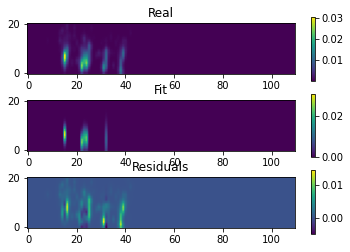

In [132]:
fitted_image = gauss_model.eval(out.params, x=X, y=Y)
fig,  ax_list = plt.subplots(3, 1)

img = ax_list[0].imshow(data_to_fit.T, origin='lower')
# fig.colorbar(img, ax=ax_list[0:2])
fig.colorbar(img, ax=ax_list[0])
ax_list[0].set_title('Real')
img = ax_list[1].imshow(fitted_image.T, origin='lower')
fig.colorbar(img, ax=ax_list[1])
ax_list[1].set_title('Fit')
img = ax_list[2].imshow(data_to_fit.T - fitted_image.T, origin='lower')
fig.colorbar(img, ax=ax_list[2])
ax_list[2].set_title('Residuals')
fig.show()
